Bud classifier: 
-  Using transfer learning with a MobileNet architecture trained on ImageNet (MobileNet: https://arxiv.org/abs/1704.04861)  
-  Using 224x224 normalized RGB patches

In [1]:
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
import numpy as np

Using TensorFlow backend.


In [2]:
import cv2
import matplotlib.pyplot as plt
import os

We define a preprocessing function that loads an image and resizes it to 224x224, using Area interpolation when shrinking and Linear Interpolation when zooming. Then we apply MinMax normalization and return the ndarray.

In [3]:
def preprocess(path):
    img = cv2.imread(path)
    if img.shape[0] > 224 and img.shape[1] > 224: 
        #shrink
        img = cv2.resize(img, (224,224),cv2.INTER_AREA)
    else: #zoom
        img = cv2.resize(img, (224,224),cv2.INTER_LINEAR)
    cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
    return img

We define lists to store training and testing samples with it's corresponding labels, and then iterate through the directories.  
Dataset structure:
-  train  
    -  bud
    -  nonbud
-  valid
    -  bud
    - nonbud

In [4]:
class_list = ['bud','non-bud']
folder_list = ['valid', 'train']
base_path = '/home/wvillegas/datasets/dharmabuds/corpus-reestructurado'
train = []
train_label = []
test = []
test_label = []

In [5]:
for folder in folder_list:
    for img_class in class_list:
        path = os.path.join(base_path, folder, img_class)
        img_path = os.listdir(path)
        for img in img_path:
            if len(train) == 10000:
                break
            if folder == 'train':
                train.append(preprocess(os.path.join(path,img)))
                if img_class == 'bud':
                    train_label.append(1) #set label to 1
                else:
                    train_label.append(0) #set label to 0
            elif folder == 'valid':
                test.append(preprocess(os.path.join(path,img)))
                if img_class == 'bud':
                    test_label.append(1) #set label to 1
                else:
                    test_label.append(0) #set label to 0
            
            
print(str(len(train)) + ' training samples preprocessed')
print(str(len(test)) + ' test samples preprocessed')

10000 training samples preprocessed
266 test samples preprocessed


We define a function to shuffle the resulting sets, we check numpy's random state and store it. Then set it just in case the state changed between the two calls to shuffle(). That way we ensure that we shuffled both sample and label arrays mantaining row correspondence.

In [7]:
def shuffle_dataset(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

Transform the lists into tensor of (list lenght, 224, 224, 3)

In [8]:
train = np.asarray(train)
train_label = np.asarray(train_label)
test = np.asarray(test)
test_label = np.asarray(test_label)
shuffle_dataset(train, train_label)
shuffle_dataset(test, test_label)

We create a MobileNet model object calling its constructor, with imagenet weights and without top layers (top layers being the fully connected layers that classify the flattened tensor of features) because we want to perform only binary classification.

In [9]:
mobilenet = MobileNet(weights='imagenet', input_shape=(224,224,3), include_top=False)

We then add our own fully connected layers. We chose to add fully connected layer with 1024 units and ReLU activation, then a single sigmoid unit to perform binary classification.

In [10]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD

In [11]:
flatten = Flatten()(mobilenet.output)
fc1 = Dense(1024, activation='relu')(flatten)
#fc2 = Dense(1024, activation='relu')(fc1)
final = Dense(1,activation='sigmoid')(fc1)
model = Model(mobilenet.input, final) 

We define an optimizer. Here we define a Stochastic Gradient Descent optimizer with a learning rate of 0.001 and momentum of 0.9.

In [12]:
optim = SGD(lr=0.001, momentum=0.9)

We compile the model and set the loss function to crossentropy.

In [13]:
model.compile(optimizer=optim,
              loss='binary_crossentropy',
              metrics=['accuracy'])

To deal with the lack of balance between both classes we set a class weight of 3 for the positive examples.  
So we are multiplying by 3 the loss that gets computed everytime that we encounter a positive sample.

In [14]:
class_weight = {0: 1.,
                1: 3.}

We train the model with a batch size of 30, during 3 epochs.

In [ ]:
history = model.fit(x=train, y=train_label,epochs=3, batch_size=30,
                     class_weight=class_weight)

Epoch 1/3
10000/10000 [==============================] - 3379s 338ms/step - loss: 0.1411 - acc: 0.9797
Epoch 2/3
 5880/10000 [================>.............] - ETA: 22:11 - loss: 0.0097 - acc: 0.9974

We then use the model to predict and test performance on the test set. We set a label of 1 for predictions above a treshold of 0.5.

In [ ]:
predictions = model.predict(test)

In [32]:
predictions_labels = (predictions > 0.5).astype(np.int_)

In [17]:
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.legend(['train_acc', 'val_acc'])
#plt.xlabel('num_batches')
#plt.title('Train Acc vs Val Acc')

Text(0.5,1,'train_loss vs val_loss')

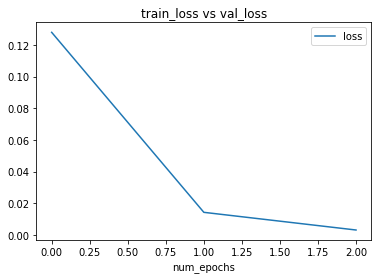

In [29]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.xlabel('num_epochs')
plt.legend(['loss', 'val_loss'])
plt.title('train_loss vs val_loss')

Prediction evaluation using the predicted labels and ground truth of the test set. (Support = Number of instances of each class for the set analised)

In [34]:
from sklearn.metrics import classification_report
print(classification_report(test_label, predictions_labels, [0,1]))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       133
          1       1.00      0.98      0.99       133

avg / total       0.99      0.99      0.99       266



In [35]:
[sum(train_label), sum(test_label)]

[657, 133]

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 16)      432       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 16)      64        
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 16)      144       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 16)      64        
__________

In [37]:
model.save(os.path.join('.','mobilenet_alpha05_10k.h5'))